<a href="https://colab.research.google.com/github/vsoumyareddy/CODSOFT/blob/main/CUSTOMER_CHURN_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bank-customer-churn-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2008274%2F3322096%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T134251Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6de48291bb9d301460d922e7e73182e06b0f11d4e5285cdcd06038e3b2ea0ad6c38944a2c3f0a81dfd6c99934e3af7fdf470f0ae424f8d69df6c84d6217de59bf86686d2909cf6b8d4ae439fe822b2a4852e3086116a18c4e056886942c4018952a422379176a264237996a17bb1971ba8e866717068d4069df84b57766e433d7522b731ebf1194cb75c588bbe2d7c8ae5b0c42346d89623cfdc7bf6b06deaa1d8a7b46ee547c9b5f473dd9f91a06cad1f9c51d532ec5af1c3aad908c5e07c20a15ba000369a0c0b21bafab853f2e7dccb131d012b4ef73cfe180101a7d49d85901221b85304384bb8c1cb88919f220bc2bd71f594d8d2f2bcc23427e4c61acd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 267794 bytes downloaded
Downloaded and uncompressed: bank-customer-churn-prediction
Data source import complete.


In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Plots

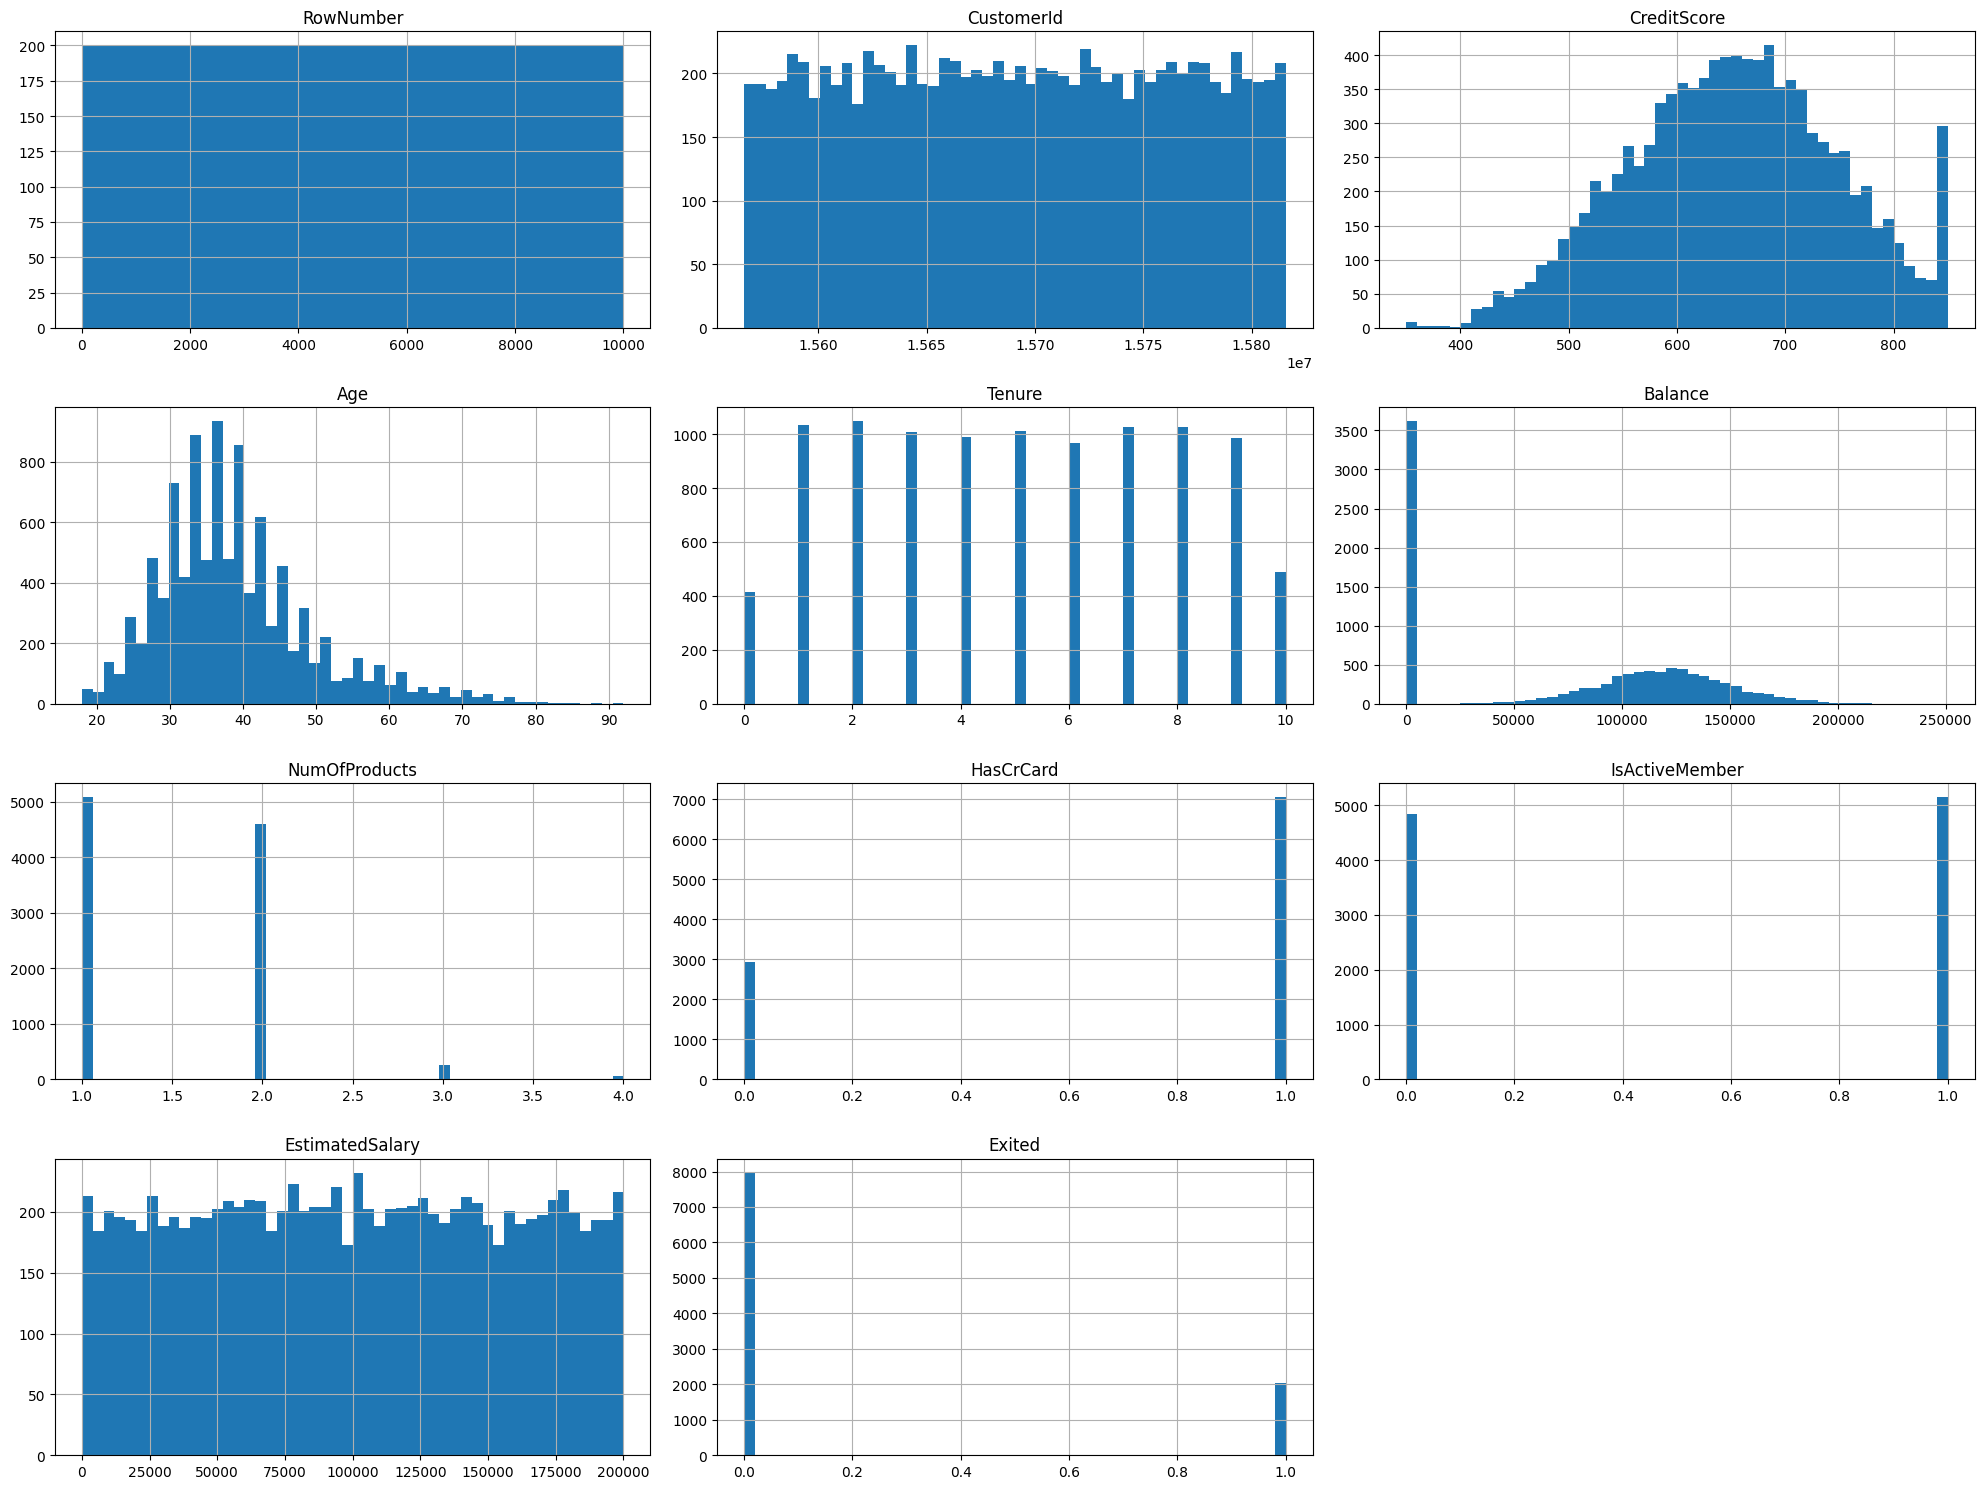

In [6]:
df.hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

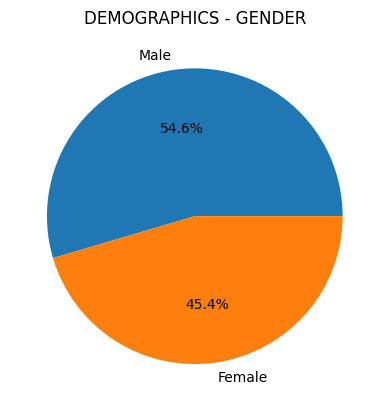

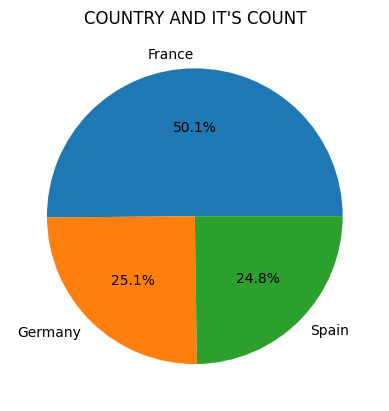

In [8]:
# Get the counts of each class
class_counts = df['Gender'].value_counts()

# Create a pie chart
plt.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%")
plt.title("DEMOGRAPHICS - GENDER")
plt.show()


# Get the counts of each class
class_counts = df['Geography'].value_counts()

# Create a pie chart
plt.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%")
plt.title("COUNTRY AND IT'S COUNT")
plt.show()

Data Preprocessing

In [9]:
df=df.drop(columns=['RowNumber','CustomerId','Surname'])

In [10]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
df['Gender']=labelencoder.fit_transform(df['Gender'])
df['Geography']=labelencoder.fit_transform(df['Geography'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [11]:
x=df.drop(columns='Exited')
y=df['Exited']

In [12]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train,y_train)
accuracy_score(y_train, lr.predict(x_train))

0.7848571428571428

In [23]:
accuracy_score(y_test, lr.predict(x_test))

0.8006666666666666

In [24]:
table_1={}
table_1["LOGISTIC REGRESSION"] = (accuracy_score(y_test, lr.predict(x_test)),
                               precision_score(y_test, lr.predict(x_test)),
                               recall_score(y_test, lr.predict(x_test)),
                               f1_score(y_test, lr.predict(x_test)))

Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(x_train,y_train)
accuracy_score(y_train, rf.predict(x_train))

0.9998571428571429

In [17]:
accuracy_score(y_test, rf.predict(x_test))

0.869

In [26]:
table_1["RANDOM FOREST"] = (accuracy_score(y_test, rf.predict(x_test)),
                               precision_score(y_test, rf.predict(x_test)),
                               recall_score(y_test, rf.predict(x_test)),
                               f1_score(y_test, rf.predict(x_test)))

Gradient Boosting

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
gb=GradientBoostingClassifier()
gb.fit(x_train,y_train)
accuracy_score(y_train, gb.predict(x_train))

0.87

In [20]:
accuracy_score(y_test, gb.predict(x_test))

0.87

In [27]:
table_1["GRADIENT BOOSTING"] = (accuracy_score(y_test, gb.predict(x_test)),
                               precision_score(y_test, gb.predict(x_test)),
                               recall_score(y_test, gb.predict(x_test)),
                               f1_score(y_test, gb.predict(x_test)))

In [28]:
pd.DataFrame(table_1, index=["accuracy", "precision", "recall", "f1score"])

,LOGISTIC REGRESSION,RANDOM FOREST,GRADIENT BOOSTING
accuracy,0.800667,0.869000,0.870000
precision,0.436364,0.775216,0.783626
recall,0.082192,0.460616,0.458904
f1score,0.138329,0.577873,0.578834
